# "A Wolf in Sheep's Clothing"
## Linguistic Cues in Social Deduction Games

<img src="illustration.png" width="42%">

_"A Wolf in Sheep's Clothing", 1920, modified ([source](https://catalog.archives.gov/id/6011601))_

|Abstract|
|---|
| We studied [[Niculae et al., 2015]](#niculae) and it enabled us to highlight certain clues of language linked to the imminence of betrayal. We would like to apply similar techniques to detect betrayal in social deduction games, like [Town of Salem](#salem), [Secret Hitler](#hitler), [Among Us](#amongus) or [Werewolf/Mafia](#mafia). Is it possible, by studying the public exchanges of the players during a textual game, to spot the "traitor"? The major difference with the basic article is that we are not looking for a betrayal to come - the breaking of a friendship - but a betrayal that has already taken place - for instance, the "wolf" seeks to win by posing as a "villager". As such, we are going to analyse textual exchanges of different games, and try to apply the same methods to multiple sessions. |

---

## Introduction

We aim to reproduce some of the techniques used in Paper X in order to find out if there is another method to identify the roles of "traitor" and betrayal within social deduction games. In particular, we use politeness and talkativeness analysis to see if it is possible to identify a "global" traitor to a game, rather than a specific betrayal.

### Linguistic Harbingers of Betrayal

The goal of this code is to give an extension to the paper [[Niculae et al., 2015]](#niculae). The paper is a study of the interpersonal relations, and more precisely of the betrayal that can occur between two people. Its goal is to see if we can predict a forthcoming betrayal with linguistic signs in a dyadic interaction. In order to do that, the authors collected the conversations of people playing a strategic game called [Diplomacy](#diplomacy) and they studied their interactions. Their study concludes that slight changes in certain attributes of the conversation may indicate impending betrayal. These indicators are as follows: positive sentiment, politeness, and focus on future planning-signal.

### How to spot a traitor

Following these indicators, we will try to take the reflection further and apply it to new issues. In particular, we are interested in knowing whether it is possible to apply the same techniques, under the same postulates, to other games, and whether it is possible to identify betrayal on a "long term" basis, i.e. deception (vs. in the article on a specific point in time). This will ideally allow us to establish the clues to identify "traitors" in social deduction games.

Due to the short time at our disposal, we focus on the study of the corpus at our disposal, its formatting, the analysis of politeness and talkativeness, and the creation of an API to be adapted according to other corpora.

### Some preliminary imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [18]:
# Path to the files containing mafiascum data
PATH_DATA = 'data'
PATH_MAFIASCUM = os.path.join(PATH_DATA, 'mafiascum','src' )
PATH_OUTPUT = os.path.join(PATH_DATA, 'output')

---

## The Mafiascum Dataset

We would like to apply similar techniques to detect betrayal in a social deduction game called [Mafia](#mafia). We found a [dataset](#deruiter) containing almost 1'100 different games. They were taken on a website called [Mafiascum](#mafia) which allows player to discuss and play this game with the help of a moderator.

The main difference between Diplomacy and and Mafia is that in the second game, the traitors are present from the beginning of the game. Their goal is to avoid to be detected and eliminate all the other players. In Diplomacy, every player can become a traitor at some point of the game. We won't look for a betrayal to come - the breaking of a friendship - but a betrayal that has already taken place. As such, we are going to analyse textual exchanges in [the game](https://www.youtube.com/watch?v=QK736KcqdK4).

### Data concierge

The first step is to import the exchanged messages from the database. They are divided in three different `json` files. We will import and concatenate them together. We will also import the `json` files containing information about the players of each game (they are also divided in three different files).

In [19]:
# Name of the files containing the data
post_files = ['mini-normal1.json', 'mini-normal2.json', 'large-normal.json']
info_files = ['mini-normal-slots.json', 'large-normal-slots.json', 'old-normal-slots.json']

# Read the files
posts_mafia = pd.concat(pd.read_json(os.path.join(PATH_MAFIASCUM, fn), orient='records') for fn in post_files)
info_mafia = pd.concat(pd.read_json(os.path.join(PATH_MAFIASCUM, fn), orient='records') for fn in info_files)

# Define the columns "game_id" and "author" as index for the first dataset
posts_mafia.set_index(['game_id', 'author'], inplace=True)

As we will see, the dataset `posts_mafia` contains 5 columns:
- **game_id:** is the number of the game in which the message was sent
- **author:** is the name of the author of the message
- **content:** the text of the post
- **inserted_at:** the time and date at which the message was posted
- **post_no:** the numbering of the posts for this game

We have defined the two first columns as index.

In [20]:
posts_mafia.head()

content  \
game_id author                                                      
29549   Tierce  Click here for games 44 through 1400.\n\nMini ...   
        Tierce  Mini Normals: 1501 - 1505\n\n\nGame 1501: We'r...   
        N       Mini Normals 1509 - 1544\n\n\nMini 1509 - Marr...   
        N       Mini Normals 1553 - 1600\n\n\nMini: 1553 Gone ...   
        N       Mini Normals 1601 - 1648\n\n\nMini 1601: B_E's...   

                       inserted_at  post_no  
game_id author                               
29549   Tierce 2013-06-25 05:19:00        0  
        Tierce 2013-12-06 13:39:00        1  
        N      2015-02-21 08:18:00        2  
        N      2015-02-21 13:09:00        3  
        N      2015-04-21 03:24:00        4

The dataset `info_mafia` contains also 5 columns:
- **game_id:** is the number of the game in which the player is playing
- **author:** is the concatenation of what we can find in the three next columns
- **users:** the nickname of the player
- **role:** the role of the player in the game
- **event:** What happened to the player during the game (did he [die](https://www.youtube.com/watch?v=AZfZnbTgY4E&t)? How? Did he [survive](https://www.youtube.com/watch?v=btPJPFnesV4)?)

Let's see it:

In [21]:
info_mafia.head()

,game_id,text,users,role,event
0,24200,"Kthxbye, Town Odd-Night Vigilante, survives",[Kthxbye],Town Odd-Night Vigilante,survives
1,24200,"Slandaar, Mafia Traitor, died Night 3",[Slandaar],Mafia Traitor,died Night 3
2,24200,"Gorgon, Vanilla Townie, survives",[Gorgon],Vanilla Townie,survives
3,24200,"Malakittens replaces theaceofspades, Town Maso...","[Malakittens, theaceofspades]",Town Mason,died Night 2
4,24200,"TheConman17, Mafia One-Shot Bulletproof, lynch...",[TheConman17],Mafia One-Shot Bulletproof,lynched Day 1


#### `info_mafia`

We will start with the second dataset `info_mafia` and find for each player if he/she's playing a betrayer role or not. A betrayer is defined as a player beeing in [the bad (and ugly?)](https://www.youtube.com/watch?v=AFa1-kciCb4) side. More precisely the roles containing one the following terms:
- mafia
- goon
- wolf
- serial killer
- SK

We will create a new column called *betrayer* in the dataframe telling with *True* or *False* if the role of the player contains one of these words.

In addition we will only keep the games in which we found a betrayer. In fact, some games have complicated roles and contain none of the listed betrayer. We only want to keep "standard" games.

In [22]:
# Look in the column role if it contains the given words 
info_mafia['betrayer'] = info_mafia['role'].str.contains('mafia|goon|wolf|serial.?killer'
                                                         , case=False) | info_mafia['role'].str.contains('SK')
# select only the games with known roles
mask_role_notnan = [not np.any(pd.isnull(info_mafia[info_mafia.game_id == g_id].role)) for g_id in info_mafia.game_id]
info_mafia = info_mafia[mask_role_notnan]

# select only the games with at least one known betrayer
mask_all_townie = [np.all(~info_mafia[info_mafia.game_id == g_id].betrayer) for g_id in info_mafia.game_id]
info_mafia = info_mafia[~np.array(mask_all_townie)]

In [23]:
info_mafia.head()

,game_id,text,users,role,event,betrayer
0,24200,"Kthxbye, Town Odd-Night Vigilante, survives",[Kthxbye],Town Odd-Night Vigilante,survives,False
1,24200,"Slandaar, Mafia Traitor, died Night 3",[Slandaar],Mafia Traitor,died Night 3,True
2,24200,"Gorgon, Vanilla Townie, survives",[Gorgon],Vanilla Townie,survives,False
3,24200,"Malakittens replaces theaceofspades, Town Maso...","[Malakittens, theaceofspades]",Town Mason,died Night 2,False
4,24200,"TheConman17, Mafia One-Shot Bulletproof, lynch...",[TheConman17],Mafia One-Shot Bulletproof,lynched Day 1,True


We also want to know if a player survived until the end of the game. We will therfore add a column called *survived* filled with *True* if the player survived or *False* if he/she died before the end of the game.

In [24]:
info_mafia['survived'] = ['survive' in str(player_event) for player_event in info_mafia.event]

In [25]:
info_mafia.head()

,game_id,text,users,role,event,betrayer,survived
0,24200,"Kthxbye, Town Odd-Night Vigilante, survives",[Kthxbye],Town Odd-Night Vigilante,survives,False,True
1,24200,"Slandaar, Mafia Traitor, died Night 3",[Slandaar],Mafia Traitor,died Night 3,True,False
2,24200,"Gorgon, Vanilla Townie, survives",[Gorgon],Vanilla Townie,survives,False,True
3,24200,"Malakittens replaces theaceofspades, Town Maso...","[Malakittens, theaceofspades]",Town Mason,died Night 2,False,False
4,24200,"TheConman17, Mafia One-Shot Bulletproof, lynch...",[TheConman17],Mafia One-Shot Bulletproof,lynched Day 1,True,False


Thanks to these information, it's now possible to find out, for each game, if the Town won or if the Mafia accomplished its mission. This can be done by comparing *survived* column with the *betrayer* one. If the player that survived are associated with *True* in *betrayer*, then the Mafia won, otherwise Town succeeded in taking the Mafia down. Note that if for a game none of the teams won, the column will remain filled with *NaN*. We will then be able to remove later these undefined cases if necessary.

In [26]:
# Create a new dataframe that will make correspond the game_id with the outcome
df_outcome = pd.DataFrame(np.unique(info_mafia.game_id), columns=['game_id']).set_index('game_id')
df_outcome['town_won'] = np.NaN

# We loop for each game
for game_id in df_outcome.index:  
    # for every players search if the event is "survive"
    outcome_town = [(player.survived == True) & (player.betrayer == False) for index, player in info_mafia[info_mafia.game_id == game_id].iterrows()]
    outcome_mafia = [(player.survived == True) & (player.betrayer == True) for index, player in info_mafia[info_mafia.game_id == game_id].iterrows()]

    if np.any(outcome_town): #if someone from town survived
        df_outcome.loc[game_id, 'town_won'] =  True
    if np.any(outcome_mafia): #if someone from mafia survived
        df_outcome.loc[game_id, 'town_won'] =  False
    
# merge with the dataframe
info_mafia = info_mafia.merge(df_outcome, on='game_id')

In [27]:
info_mafia.head()

,game_id,text,users,role,event,betrayer,survived,town_won
0,24200,"Kthxbye, Town Odd-Night Vigilante, survives",[Kthxbye],Town Odd-Night Vigilante,survives,False,True,True
1,24200,"Slandaar, Mafia Traitor, died Night 3",[Slandaar],Mafia Traitor,died Night 3,True,False,True
2,24200,"Gorgon, Vanilla Townie, survives",[Gorgon],Vanilla Townie,survives,False,True,True
3,24200,"Malakittens replaces theaceofspades, Town Maso...","[Malakittens, theaceofspades]",Town Mason,died Night 2,False,False,True
4,24200,"TheConman17, Mafia One-Shot Bulletproof, lynch...",[TheConman17],Mafia One-Shot Bulletproof,lynched Day 1,True,False,True


Before finishing with this dataframe, we have to deal with another particularity. Sometimes a player is replaced by another one during a game. In this case, the players are all written in the *users* column. We have then to separate this column and create a line per user. In addition we will only keep the columns we will need later (*game_id*, *users*, *survived*, *betrayer* and town_won) and put them in a new dataframe called `betrayer_df`. 

We will also rename the name of the column *users* and name it *author* in order to be consistent with the other dataframe. Finaly we will define the columns *game_id* and *author* as index. Thus we will have the same index as the other dataframe and it will be easier to merge them later.

In [28]:
# Seperate the users and create the new dataframe
betrayer_df = info_mafia.explode('users')[['game_id', 'users', 'survived', 'betrayer', 'town_won']]

# Change name of the users column and set index to correspond with the other dataframe
betrayer_df.rename(columns ={'users':'author'}, inplace = True)
betrayer_df.set_index(['game_id', 'author'], inplace = True)

In [29]:
betrayer_df.head()

survived  betrayer town_won
game_id author                                     
24200   Kthxbye             True     False     True
        Slandaar           False      True     True
        Gorgon              True     False     True
        Malakittens        False     False     True
        theaceofspades     False     False     True

Now we have the information we want for this dataframe.

#### `posts_mafia`
We will now start playing with the other one.

In the `posts_mafia` dataframe we can find all the messages posted during each game. But a part of the messages were sent by the moderator of the game. His goal is to guide players through the game. He will make some announcement for starting the game and ending the game. He will also collect the votes that will choose the people who will be eliminated by the players.

As we only want to study the behaviour of the players we find the messages sent by the moderator. In order to do that we will look for the very first message sent in every game. This message is always sent by the moderator who introduce the new game. By doing this, we can find the moderator's nickname and thus find all his messages.

In [30]:
# We want to find each messages sent by the moderator: the first post of each game is always sent by the moderator
first_posts = posts_mafia[posts_mafia["post_no"] == 0]

In [31]:
first_posts.head()

,,content,inserted_at,post_no
game_id,author,,,
29549,Tierce,Click here for games 44 through 1400.\n\nMini ...,2013-06-25 05:19:00,0
71796,PenguinPower,Welcome to Mini Normal 1911 \nPenguin Mafia R...,2017-05-12 11:45:00,0
71697,nancy,Welcome to Girls ♥ Girls Mini 1909\nPart 1: On...,2017-05-02 22:15:00,0
71675,XnadrojX,Welcome to Mini Normal 1908 - In The Web\nI am...,2017-05-02 06:30:00,0
71640,Dierfire,Mini Normal 1905\nModerator: Dierfire\nReviewe...,2017-04-29 18:37:00,0


We can see for example that the moderator of the first game in the database is called *Tierce*.

Now we can find all the messages sent by the moderator in each game.

In [32]:
# look for all the posts sent by the moderator in each game
moderator_posts = posts_mafia.loc[first_posts.index]

In [33]:
moderator_posts.head()

content  \
game_id author                                                            
29549   Tierce        Click here for games 44 through 1400.\n\nMini ...   
        Tierce        Mini Normals: 1501 - 1505\n\n\nGame 1501: We'r...   
71796   PenguinPower  Welcome to Mini Normal 1911  \nPenguin Mafia R...   
        PenguinPower  Rules\nRules shamelessly stolen from various m...   
        PenguinPower  Role PMs have been sent out.  Game will start ...   

                             inserted_at  post_no  
game_id author                                     
29549   Tierce       2013-06-25 05:19:00        0  
        Tierce       2013-12-06 13:39:00        1  
71796   PenguinPower 2017-05-12 11:45:00        0  
        PenguinPower 2017-05-12 11:52:00        1  
        PenguinPower 2017-05-12 12:47:00        2

After the game is over, players often start talking about what happened during the game, bragging about their merits or despairing about the fact that they think they were killed unjustly. We are not interested in this part of the discussion because by that time the roles of the players will have been revealed and therefore there is no more betrayer. Therefore we want to eliminate all these messages.

First of all, we will search in the messages sent by the moderator for all those that give the result of a vote. Indeed, a game ends with the elimination of a player leading to the victory of one of the two sides (["the good guys" or "the bad guys"](https://www.youtube.com/watch?v=gDIlTlkOBYc) depending on how you see things).

In [34]:
# We search in the messages sent by the moderator the posts telling the results of the votes
vote_counts = moderator_posts[moderator_posts["content"].str.contains("vote ?count|vc|not voting \(", case=False)].copy()

In [35]:
vote_counts.head()

content  \
game_id author                                                            
71796   PenguinPower  Welcome to Mini Normal 1911  \nPenguin Mafia R...   
        PenguinPower  Vote Count 1.01\nNot Voting (13): Transcend, L...   
        PenguinPower  Vote Count 1.02\nGamma Emerald (2): Transcend,...   
        PenguinPower  Vote Count 1.03\nMulch (3): Agent Sparkles, Ry...   
        PenguinPower  Vote Count 1.04\nAgent Sparkles (2): Transcend...   

                             inserted_at  post_no  
game_id author                                     
71796   PenguinPower 2017-05-12 11:45:00        0  
        PenguinPower 2017-05-12 19:49:00        4  
        PenguinPower 2017-05-12 20:40:00       25  
        PenguinPower 2017-05-13 00:39:00      112  
        PenguinPower 2017-05-13 01:43:00      153

Now we can find the post of the moderator ending a game. This is simply the last post talking about a vote. Let's find that!

In [36]:
# Find for each game the last post talking about a vote => the end of the game.
last_posts = vote_counts['post_no'].max(level=0)

In [37]:
last_posts.head()

game_id
71796    3130
71697    4741
71675    3256
71640    3354
71483    2596
Name: post_no, dtype: int64

We have now for each game the number of the message which is ending the game. We will add to the `posts_mafia` dataframe a new column called `post_no_last` telling this number.

In [38]:
# Add a new column with the number of the last message
posts_mafia = posts_mafia.join(last_posts, rsuffix='_last', how='inner')

In [39]:
posts_mafia.head()

content  \
game_id author                                                            
71796   PenguinPower  Welcome to Mini Normal 1911  \nPenguin Mafia R...   
        PenguinPower  Rules\nRules shamelessly stolen from various m...   
        PenguinPower  Role PMs have been sent out.  Game will start ...   
        PenguinPower                                  Day 1 Starts Now!   
        PenguinPower  Vote Count 1.01\nNot Voting (13): Transcend, L...   

                             inserted_at  post_no  post_no_last  
game_id author                                                   
71796   PenguinPower 2017-05-12 11:45:00        0          3130  
        PenguinPower 2017-05-12 11:52:00        1          3130  
        PenguinPower 2017-05-12 12:47:00        2          3130  
        PenguinPower 2017-05-12 19:47:00        3          3130  
        PenguinPower 2017-05-12 19:49:00        4          3130

Now we can eliminate all the lines that have a *post_no* higher than the *post_no_last*. That means that the massage was sent after the moderator ended the game.

In [40]:
#keep only thes ligne that have a lower or equal message's number than the "last message number"
posts_mafia = posts_mafia[posts_mafia['post_no'] <= posts_mafia['post_no_last']]

In [41]:
posts_mafia.head()

content  \
game_id author                                                            
71796   PenguinPower  Welcome to Mini Normal 1911  \nPenguin Mafia R...   
        PenguinPower  Rules\nRules shamelessly stolen from various m...   
        PenguinPower  Role PMs have been sent out.  Game will start ...   
        PenguinPower                                  Day 1 Starts Now!   
        PenguinPower  Vote Count 1.01\nNot Voting (13): Transcend, L...   

                             inserted_at  post_no  post_no_last  
game_id author                                                   
71796   PenguinPower 2017-05-12 11:45:00        0          3130  
        PenguinPower 2017-05-12 11:52:00        1          3130  
        PenguinPower 2017-05-12 12:47:00        2          3130  
        PenguinPower 2017-05-12 19:47:00        3          3130  
        PenguinPower 2017-05-12 19:49:00        4          3130

Finaly we can now delete the messages sent by the moderators during the games. We will create a new dataframe called `messages_players` containing only the messages sent by the players during the games.

In [42]:
# redefine the indexes of the dataframe to make them unique
no_posts_mafia = posts_mafia.reset_index().set_index(['game_id', 'author', 'post_no'])
no_moderator_posts = moderator_posts.reset_index().set_index(['game_id', 'author', 'post_no'])

# Keep only the messages that were not send by the moderator
messages_players = no_posts_mafia[~no_posts_mafia.index.isin(no_moderator_posts.index)].reset_index()
messages_players.set_index(['game_id', 'author'], inplace = True )

In [43]:
messages_players.head()

post_no  \
game_id author                   
71796   Gamma Emerald        5   
        Transcend            6   
        Gamma Emerald        7   
        Mulch                8   
        Gamma Emerald        9   

                                                                 content  \
game_id author                                                             
71796   Gamma Emerald  Opening with RQS\n1) How excited are you for t...   
        Transcend                                            VOTE: gamma   
        Gamma Emerald  My answers\n1) I'm quite excited, I played PP'...   
        Mulch                                                WTF are RQS   
        Gamma Emerald  RQS is random questioning stage, it's a type o...   

                              inserted_at  post_no_last  
game_id author                                           
71796   Gamma Emerald 2017-05-12 19:49:00          3130  
        Transcend     2017-05-12 19:51:00          3130  
        Gamma Emerald 2017-05-12 19:55:00          3130  
        Mulch         2017-05-12 20:02:00          3130  
        Gamma Emerald 2017-05-12 20:04:00          3130

#### Merging

Now we can merge the two dataframes `messages_players` and `betrayer_df`.

In [44]:
messages_players = messages_players.merge(betrayer_df, left_index = True, right_index = True).reset_index()

In [45]:
messages_players.head()

,game_id,author,post_no,content,inserted_at,post_no_last,survived,betrayer,town_won
0,26,CoolBot,27,\n\nThis sounds like you're trying to limit an...,2003-07-24 21:28:00,273,False,False,NaN
1,26,CoolBot,40,It was Someone's suggesting he didn't want ano...,2003-07-25 17:48:00,273,False,False,NaN
2,26,CoolBot,65,I'm not really sure how a neutral role would e...,2003-07-28 15:44:00,273,False,False,NaN
3,26,CoolBot,85,So the robot detector... is a robot? I don't ...,2003-07-29 01:09:00,273,False,False,NaN
4,26,CoolBot,99,Has anyone considered that maybe Someone is a ...,2003-07-29 18:14:00,273,False,False,NaN


In [46]:
# messages of players for games with known outcomes
messages_players_outcome = messages_players[~pd.isnull(messages_players.town_won)]
print('At this step, there are {0} games with known outcomes.'.format(len(np.unique(messages_players_outcome.game_id))))

At this step, there are 306 games with known outcomes.


In [47]:
messages_players_outcome.head()

,game_id,author,post_no,content,inserted_at,post_no_last,survived,betrayer,town_won
172608,15557,ConfidAnon,11,/confirm.,2010-10-29 01:37:00,825,True,True,False
172609,15557,ConfidAnon,41,I'm fine with kicking off a mass claim if a ma...,2010-10-30 08:29:00,825,True,True,False
172610,15557,ConfidAnon,77,\n\nI agree here. It seems very unlikely for ...,2010-10-31 20:27:00,825,True,True,False
172611,15557,Fenhl,570,"Hi everybody!\nAs announced by Fishythefish, I...",2010-12-16 19:20:00,825,True,True,False
172612,15557,Fenhl,571,"I have a smartphone and access from school, so...",2010-12-16 23:24:00,825,True,True,False


In [48]:
# How many games are left
len(np.unique(messages_players.reset_index().game_id))

619

Now we have a merged dataframe that keeps only the informations we need. We can see that some of the games we had at the beginning are no longer present in this database: the database is now shorter. Indeed, when we merged the two dataframe, a part of the correspondences could not be made because the indexes on which the merging was made were not present in the two tables (for example the role of a player is unknown). We now have 619 games left.

####  Timing is everything

The next step is now to classify the messages in a time frame for each game. We will add temporal markers to this dataset in order to be able to study the evolution of some features. We will also try to find to which round of the game each message belongs. 

We will first start by adding temporal markers to the messages. The simplest way to do so is by using the timestamps *inserted_at* and normalizing on the game in order to get comparable values across games.

First each message will be associated with a relative in game time (0: beginning, 1: end). Let's begin by defining a DataFrame with major information about times of the game (start, end, length).

In [49]:
# Create a new dataframe that will contains the starting time of the game, the ending time and the length
df_game_times = pd.DataFrame(np.unique(messages_players.game_id), columns=['game_id']) 

# The starting time is simply the time when the moderator sent his first message
df_game_times['start_time'] = [moderator_posts.loc[game_id,:].inserted_at.iloc[0] for game_id in df_game_times.game_id]

# The ending time is when the moderator announce the results of the final votes
df_game_times['end_time'] = [moderator_posts.loc[game_id,:][moderator_posts.loc[game_id,:].post_no == last_posts.loc[game_id]].inserted_at[-1]
           for game_id in df_game_times.game_id]

# Calculate the length of the game (length = end - start)
df_game_times['time_length'] = df_game_times['end_time']-df_game_times['start_time']

df_game_times = df_game_times.set_index('game_id')

In [50]:
df_game_times.head()

,start_time,end_time,time_length
game_id,,,
26,2003-07-23 19:05:00,2003-09-02 19:14:00,41 days 00:09:00
28,2003-07-23 20:47:00,2003-08-06 20:18:00,13 days 23:31:00
38,2003-07-25 00:06:00,2003-08-22 04:15:00,28 days 04:09:00
94,2003-08-08 01:32:00,2003-08-22 21:12:00,14 days 19:40:00
135,2003-08-31 20:07:00,2003-10-07 23:37:00,37 days 03:30:00


These information can then be used to normalize the timestamp of each message with relation to its game.

In [52]:
# That cell is hella long beware
rel_time = []

# for each message we will add a new column containing the relative time (in the game) when the message was sent
for index, row_posts in tqdm(messages_players.iterrows(), total=messages_players.shape[0]):
    game_id = row_posts.game_id
    rel_time.append((row_posts.inserted_at - df_game_times.loc[game_id].start_time)/df_game_times.loc[game_id].time_length)

#add the new column
messages_players['rel_time'] = rel_time

In [53]:
messages_players.head()

,game_id,author,post_no,content,inserted_at,post_no_last,survived,betrayer,town_won,rel_time
0,26,CoolBot,27,\n\nThis sounds like you're trying to limit an...,2003-07-24 21:28:00,273,False,False,NaN,0.026808
1,26,CoolBot,40,It was Someone's suggesting he didn't want ano...,2003-07-25 17:48:00,273,False,False,NaN,0.047469
2,26,CoolBot,65,I'm not really sure how a neutral role would e...,2003-07-28 15:44:00,273,False,False,NaN,0.118529
3,26,CoolBot,85,So the robot detector... is a robot? I don't ...,2003-07-29 01:09:00,273,False,False,NaN,0.128097
4,26,CoolBot,99,Has anyone considered that maybe Someone is a ...,2003-07-29 18:14:00,273,False,False,NaN,0.145455


Now that we have achieved the expected result, let's try to find the rounds ! At first glance it doesn't seem very complicated, but unfortunately a lot of parameters complicate things. First of all, the moderators are different from game to game. So we cannot rely on words they might say because they change every time. Then there are also no *Bot* that punctuates the game in a regular way. And icing on the cake, the moderators don't just talk between rounds, but also makes comment during the game.

However in some games finding rounds can be done by retrieving a common pattern in the moderator's votecount messages. It can be noticed by investigating the messages sent that some moderators (sadly not all of them) specify a [deadline](https://www.youtube.com/watch?v=jR9Rl-gFi6o) to the current vote session with a common structure : `Deadline: (expired on TIMESTAMP)` (see example below). Finding the post number associated with the last message in which meticulous moderators used a specific deadline timestamp is then a way to cut these games into rounds.

In [54]:
# printing an example of moderator's post mentionning "expired on "
example_index = 2
print('Post number {post_number}, posted at {timestamp}, by {mod} in game {game_id} : \n"\n{content}"'.format(
    post_number = vote_counts.post_no.iloc[example_index],
    timestamp = vote_counts.inserted_at.iloc[example_index],
    mod = vote_counts.index[example_index][1],
    game_id = vote_counts.index[example_index][0],
    content = vote_counts.content.iloc[example_index]))

Post number 25, posted at 2017-05-12 20:40:00, by PenguinPower in game 71796 : 
"
Vote Count 1.02
Gamma Emerald (2): Transcend, FireScreamer
Tammy (2): marshy, Zulfy 
Agent Sparkles (1): Ranmaru
Mulch (1): Agent Sparkles

Not Voting (7): LaLight, Mulch, Ryker, Tammy, AdumbroDeus, FrozenFlame, Gamma Emerald

With 13 alive, it takes 7 to lynch.

Deadline: (expired on 2017-05-26 16:00:00)

Mod Notes:  Not sure I like this automatic vote counter thing.  Edit:  Think I found a work around.
"


First let's modify the `vote_counts` DataFrame by dropping the *author* column as it doesn't bring any information to know the moderator's pseudonym, plus add a column with the timestamp associated with the sequence "expired on " if it is present in each of the messages contained in the DataFrame.

In [55]:
vote_counts_per_game = vote_counts.reset_index(level=1, drop=True).copy() # author brings no information
# add column to the DF w/ timestamp if it follows the targeted pattern
vote_counts_per_game['round_expired'] = [pd.to_datetime(vc_message.split("expired on ",1)[1][:19])
                      if ("expired on " in vc_message) else pd.NaT
                      for vc_message in vote_counts.content]

In [56]:
vote_counts_per_game.head()

,content,inserted_at,post_no,round_expired
game_id,,,,
71796,Welcome to Mini Normal 1911 \nPenguin Mafia R...,2017-05-12 11:45:00,0,NaT
71796,"Vote Count 1.01\nNot Voting (13): Transcend, L...",2017-05-12 19:49:00,4,2017-05-26 16:00:00
71796,"Vote Count 1.02\nGamma Emerald (2): Transcend,...",2017-05-12 20:40:00,25,2017-05-26 16:00:00
71796,"Vote Count 1.03\nMulch (3): Agent Sparkles, Ry...",2017-05-13 00:39:00,112,2017-05-26 16:00:00
71796,Vote Count 1.04\nAgent Sparkles (2): Transcend...,2017-05-13 01:43:00,153,2017-05-26 16:00:00


Based on the added column *round_expired*, a DataFrame containing information about each of the games with conscientious moderators can be built. It aims at gathering the indexes of such games and the posts numbers than mark the end of rounds (ie. last time a specific timestamp is used as a deadline).

In [57]:
# find all the games in which "expired on " is mentionned at least once
game_expired_mention = np.unique(vote_counts_per_game[~pd.isnull(vote_counts_per_game.round_expired)].index)
# build a DF to gather informations about these games
df_expired = pd.DataFrame(game_expired_mention, columns=['game_id']).set_index('game_id')

# add a column with all the different deadlines used by the mod
unique_round_expired = []

for game_id in df_expired.index:
    unique_round_expired.append(np.unique(vote_counts_per_game.loc[game_id].round_expired))
    unique_round_expired[-1] = unique_round_expired[-1][~pd.isnull(unique_round_expired[-1])]
    
df_expired['unique_round_expired'] = unique_round_expired

# select only the games within which moderator stated at least 2 different deadlines
df_expired['nb_rounds'] = [len(game_rounds_ts) for game_rounds_ts in df_expired.unique_round_expired]
df_expired = df_expired[df_expired.nb_rounds>1]

# retrieving the post number associated with the end of a round
df_expired['end_round_post_no'] = [np.array([vote_counts_per_game.loc[game_id][vote_counts_per_game.loc[game_id].round_expired == pd.to_datetime(date)].post_no.iloc[-1]
                                             for date in df_expired.loc[game_id].unique_round_expired])
                                   for game_id in df_expired.index]

In [58]:
df_expired.head()

,unique_round_expired,nb_rounds,end_round_post_no
game_id,,,
17173,"[2011-05-14T12:00:00.000000000, 2011-05-17T19:...",8,"[736, 740, 850, 868, 931, 939, 892, 932]"
17407,"[2011-06-09T23:00:00.000000000, 2011-06-26T02:...",3,"[1012, 1263, 1356]"
17666,"[2011-06-15T16:00:00.000000000, 2011-06-24T10:...",6,"[142, 349, 483, 627, 676, 688]"
17864,"[2011-07-19T17:00:00.000000000, 2011-07-22T17:...",3,"[880, 1018, 1489]"
18287,"[2011-08-01T18:00:00.000000000, 2011-08-03T13:...",6,"[470, 540, 830, 1024, 1060, 1072]"


Within this games' subset, the messages sent by the players can be categorized according to the round they were sent. This is done by selecting a reduced DataFrame within `messages_players` and computing the number of posts marking the end of rounds that occur before each of the players message is sent.

In [59]:
# reducing to the games of interest
messages_players_expired = messages_players[messages_players.game_id.isin(df_expired.index)].copy()

# adding the `rounds` column
mess_expired_round = []

for index, row_posts in tqdm(messages_players_expired.iterrows(), total=messages_players_expired.shape[0]):
    game_id = row_posts.game_id
    mess_expired_round.append(np.sum(row_posts.post_no > df_expired.loc[game_id].end_round_post_no))

messages_players_expired['rounds'] = mess_expired_round

In [60]:
messages_players_expired.head()

,game_id,author,post_no,content,inserted_at,post_no_last,survived,betrayer,town_won,rel_time,rounds
188456,17173,Elsa von Spielburg,11,Vote: McGriddle\n\nWhy would you tout the prod...,2011-04-07 20:55:00,939,False,False,False,0.046744,0
188457,17173,Elsa von Spielburg,23,"Really, Occult (and others), how often does th...",2011-04-08 17:28:00,939,False,False,False,0.059936,0
188458,17173,Elsa von Spielburg,30,"\n\nAgreed, the RVS is largely useless until s...",2011-04-08 21:05:00,939,False,False,False,0.062257,0
188459,17173,Elsa von Spielburg,31,"\n\nWho is the ""he"" in this sentence. I don't...",2011-04-08 21:08:00,939,False,False,False,0.062289,0
188460,17173,Elsa von Spielburg,42,"\n\nYeah, I'm wondering how being the 2nd vote...",2011-04-09 02:33:00,939,False,False,False,0.065767,0


In [61]:
messages_players_expired_outcome = messages_players_expired[~pd.isnull(messages_players_expired.town_won)]
print(len(np.unique(messages_players_expired_outcome.game_id)))

220


Now we have two dataframe. One containing 231 games with the messages that are separated by round and another one with 637 games with messages that have only a time code that tell when they were sent during the game (relative time).

In [62]:
print(len(np.unique(messages_players_expired.game_id)))

231


In [63]:
messages_players_expired_outcome_survivors = messages_players_expired_outcome[messages_players_expired_outcome.survived]

In [64]:
messages_players_expired_outcome_survivors.head()

,game_id,author,post_no,content,inserted_at,post_no_last,survived,betrayer,town_won,rel_time,rounds
188580,17173,Hero764,143,"Hey sorry for the absence, this isn't normal s...",2011-04-12 23:53:00,939,True,False,False,0.125681,0
188768,17173,Occult,6,Vote,2011-04-07 18:34:00,939,True,True,False,0.045235,0
188769,17173,Occult,10,The blank vote is quite symbolic.,2011-04-07 20:07:00,939,True,True,False,0.046230,0
188770,17173,Occult,19,\n\nI assumed the point of the RVS was to rand...,2011-04-08 14:50:00,939,True,True,False,0.058245,0
188771,17173,Occult,21,"You see that is a bit of a WIFOM, isn't it? In...",2011-04-08 15:23:00,939,True,True,False,0.058598,0


In [65]:
messages_players.to_pickle(os.path.join(PATH_OUTPUT, 'messages_players.pkl'))
messages_players_expired.to_pickle(os.path.join(PATH_OUTPUT, 'messages_players_expired.pkl'))
messages_players_expired_outcome.to_pickle(os.path.join(PATH_OUTPUT, 'messages_players_expired_outcome.pkl'))
messages_players_expired_outcome_survivors.to_pickle(os.path.join(PATH_OUTPUT, 'messages_players_expired_outcome_survivors.pkl'))

In [66]:
messages_players_expired.head()

,game_id,author,post_no,content,inserted_at,post_no_last,survived,betrayer,town_won,rel_time,rounds
188456,17173,Elsa von Spielburg,11,Vote: McGriddle\n\nWhy would you tout the prod...,2011-04-07 20:55:00,939,False,False,False,0.046744,0
188457,17173,Elsa von Spielburg,23,"Really, Occult (and others), how often does th...",2011-04-08 17:28:00,939,False,False,False,0.059936,0
188458,17173,Elsa von Spielburg,30,"\n\nAgreed, the RVS is largely useless until s...",2011-04-08 21:05:00,939,False,False,False,0.062257,0
188459,17173,Elsa von Spielburg,31,"\n\nWho is the ""he"" in this sentence. I don't...",2011-04-08 21:08:00,939,False,False,False,0.062289,0
188460,17173,Elsa von Spielburg,42,"\n\nYeah, I'm wondering how being the 2nd vote...",2011-04-09 02:33:00,939,False,False,False,0.065767,0


In [67]:
len(messages_players_expired)

422903

---

## Now for (more) code !

### General functions

In [68]:
def bootstrap_CI_median(data, nbr_draws=1000, ci=95):
    """
    Role : compute the given confidence interval (CI) around the mean of an array of values

    # PARAMETERS
    data : array containing the values on which we want to compute the mean (and thus CI)
    nbr_draws : integer defining the number of random selections when bootstraping data
    ci : float (default 95) defines the amount of precision wanted in percentage

    # RETURN
    list containing the CI around the mean : [2.5 percentile, 97.5 percentile]
    """
    # compute the percentiles according to the given confidence interval
    low_perc = (100 - ci) / 2
    high_perc = 100 - low_perc

    # defining arrays that will be filled during the random bootstraps
    medians = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(
            0, len(data), len(data)
        )  # random selection of data in the data array (with replacement)
        data_tmp = data[
            indices
        ]  # creation of a new array of values from the data values
        medians[n] = np.nanmedian(data_tmp)  # calculate the mean of the new array of values

    return np.array(
        [np.nanpercentile(medians, low_perc), np.nanpercentile(medians, high_perc)]
    )

### Politeness

For politeness, we are going to use [ConvKit](convkit), which contains an implementation of the [Stanford Politeness API](#convkit), as the paper stated to use.

In [ ]:
TEST = True  # Set to True to use a subset of the dataset, False to use the whole dataset.

In [69]:
try:
    messages_players_expired.head()
except Exception as e:
    print("Warning: {}.".format(e))
    print("Trying to load it from disk.")
    try:  # Run the cells in #Some-preliminary-imports before!
        messages_players_expired = pd.read_pickle(os.path.join(PATH_OUTPUT, 'messages_players_expired.npy'))
        messages_players_expired.head()
        print("Loaded from disk.")
    except Exception as e:
        print("Error: {}.".format(e))

In [70]:
try:
    import convokit
except:
    !pip install convokit
    !python -m spacy download en  # Need sudo!
    import convokit

#### Creation of the corpus

First of all we are going to create a Corpus to use with ConvKit. A Corpus is a data format used by ConvKit, and is basically a list of Conversations. Each Conversation can hve one or more participants, called the Speakers, and each Speaker can say things, refered as Utterances. As stated by [the official documentation](#convkit), "the Corpus class stores a list of Utterance objects, which may be grouped together into one or more instances of Conversation, and each Utterance has an associated Speaker".

As multiple players may partake in different games, we will try to separate them and consider them "unique" per game, because the language used will depend on the role - or so is our theory.

We start to `group_by` by `game_id` so that we can get the unique players.

In [71]:
from convokit import Corpus, Speaker, Utterance
from collections import defaultdict

In [72]:
grouped_games = messages_players_expired.groupby(['game_id', 'author'])

In [73]:
grouped_games.first()

post_no  \
game_id author                        
17173   Elsa von Spielburg       11   
        Empking                   9   
        Hero764                 143   
        HezLucky                 12   
        Internet Stranger         4   
...                             ...   
71796   Tammy                   247   
        Titus                  2460   
        Transcend                 6   
        Zulfy                    11   
        marshy                   16   

                                                                      content  \
game_id author                                                                  
17173   Elsa von Spielburg  Vote: McGriddle\n\nWhy would you tout the prod...   
        Empking                                             Vote: Kanye - Gut   
        Hero764             Hey sorry for the absence, this isn't normal s...   
        HezLucky            Hi all I've got a final tomorrow so this is th...   
        Internet Stranger                             FRIST!\n\nVote: Jeromus   
...                                                                       ...   
71796   Tammy               Hi Ranmaru, Gamma and Transcend and everyone e...   
        Titus                            Ok where are we? What claims we got?   
        Transcend                                                 VOTE: gamma   
        Zulfy                             Transcend didnt like your rqs gamma   
        marshy              I DECLARE THE END OF RQS AND THE BEGINNING OF ...   

                                   inserted_at  post_no_last  survived  \
game_id author                                                           
17173   Elsa von Spielburg 2011-04-07 20:55:00           939     False   
        Empking            2011-04-07 19:27:00           939     False   
        Hero764            2011-04-12 23:53:00           939      True   
        HezLucky           2011-04-07 21:25:00           939     False   
        Internet Stranger  2011-04-07 18:21:00           939     False   
...                                        ...           ...       ...   
71796   Tammy              2017-05-13 04:20:00          3130     False   
        Titus              2017-05-31 18:15:00          3130     False   
        Transcend          2017-05-12 19:51:00          3130      True   
        Zulfy              2017-05-12 20:20:00          3130     False   
        marshy             2017-05-12 20:30:00          3130     False   

                            betrayer town_won  rel_time  rounds  
game_id author                                                   
17173   Elsa von Spielburg     False    False  0.046744       0  
        Empking                False    False  0.045802       0  
        Hero764                False    False  0.125681       0  
        HezLucky               False    False  0.047065       0  
        Internet Stranger       True    False  0.045096       0  
...                              ...      ...       ...     ...  
71796   Tammy                  False    False  0.027222       0  
        Titus                  False    False  0.759213       2  
        Transcend               True    False  0.013296       0  
        Zulfy                  False    False  0.014090       0  
        marshy                 False    False  0.014363       0  

[3997 rows x 9 columns]

Now, we will create the list of "unique" players. We will retain the following informations: `game_id`, `author`, `num_posts`, `survived`, `betrayer`, `town_won`.

In [74]:
corpus_authors = {}
for (game_id, author), group in tqdm(grouped_games):
    idx = "{}_{}".format(game_id, author)
    meta = {
        'game_id': game_id,
        'author': author,
        'num_posts': len(group),
        'survived': group['survived'].iloc[0],
        'betrayer': group['betrayer'].iloc[0],
        'town_won': group['town_won'].iloc[0],
    }
    corpus_authors[idx] = Speaker(id=idx, meta=meta)

From that, we create the corpus of players.

In [75]:
print("We have {} \"unique\" players.".format(len(corpus_authors)))

We have 3997 "unique" players.


Next, we are making utterances, i.e. "messages". Each message will be mapped to a conversation and a player.

In [76]:
corpus_utterances = {}
for (game_id, author), group in tqdm(grouped_games):
    author = "{}_{}".format(game_id, author)
    for idx, row in group.iterrows():
        meta = {
            'game_id': row['game_id'],
            'post_no': row['post_no'],
            'date': row['inserted_at'],
            'rel_time': row['rel_time'],
            'round': row['rounds'],
        }
        
        corpus_utterances[idx] = Utterance(id=str(idx),
                                           speaker=corpus_authors[author],
                                           text=row['content'],
                                           meta=meta,
                                           conversation_id=str(game_id),
                                           reply_to=None)

In [77]:
print("We have {} utterances.".format(len(corpus_utterances)))

We have 422903 utterances.


Our Corpus is almost ready to be used...

In [135]:
list_utterances = corpus_utterances.values()
corpus = Corpus(utterances=list_utterances)

In [136]:
corpus.print_summary_stats()

Number of Speakers: 3997
Number of Utterances: 422903
Number of Conversations: 231


Numbers check out! We are going to save that thing so that we do not need to create it again.

In [83]:
if not os.path.exists(os.path.join(PATH_OUTPUT, "corpus")):
    os.makedirs(os.path.join(PATH_OUTPUT, "corpus"))
corpus.dump("corpus", base_path=os.path.join(PATH_OUTPUT, "corpus"))

#### Preprocessing

Some NLP magic will take place in front of your amazed eyes. First of all, we are going to parse our texts (=tokenization), so that we can use ConvoKit's models.

In [84]:
# ... I am not sure how to load it from disck lmao.

In [85]:
from convokit import TextParser
parser = TextParser(verbosity=1000)

In [158]:
if TEST:
    corpus.filter_conversations_by(lambda convo: convo.id[:2] == '69')  # Warning, in place!
    corpus.print_summary_stats()

In [160]:
corpus_parsed = parser.transform(corpus)  # Looooooong, about 8s per 1k, so about one hour!

1000/32022 utterances processed
2000/32022 utterances processed
3000/32022 utterances processed
4000/32022 utterances processed
5000/32022 utterances processed
6000/32022 utterances processed
7000/32022 utterances processed
8000/32022 utterances processed
9000/32022 utterances processed
10000/32022 utterances processed
11000/32022 utterances processed
12000/32022 utterances processed
13000/32022 utterances processed
14000/32022 utterances processed
15000/32022 utterances processed
16000/32022 utterances processed
17000/32022 utterances processed
18000/32022 utterances processed
19000/32022 utterances processed
20000/32022 utterances processed
21000/32022 utterances processed
22000/32022 utterances processed
23000/32022 utterances processed
24000/32022 utterances processed
25000/32022 utterances processed
26000/32022 utterances processed
27000/32022 utterances processed
28000/32022 utterances processed
29000/32022 utterances processed
30000/32022 utterances processed
31000/32022 utteran

We know add the different politeness strategies to compute the politeness score.

In [161]:
from convokit import PolitenessStrategies
ps = PolitenessStrategies()

In [186]:
corpus_politeness = ps.transform(corpus_parsed, markers=True)

We can check that we now have indeed politeness scores attached to our Corpus using a handy built-in function:

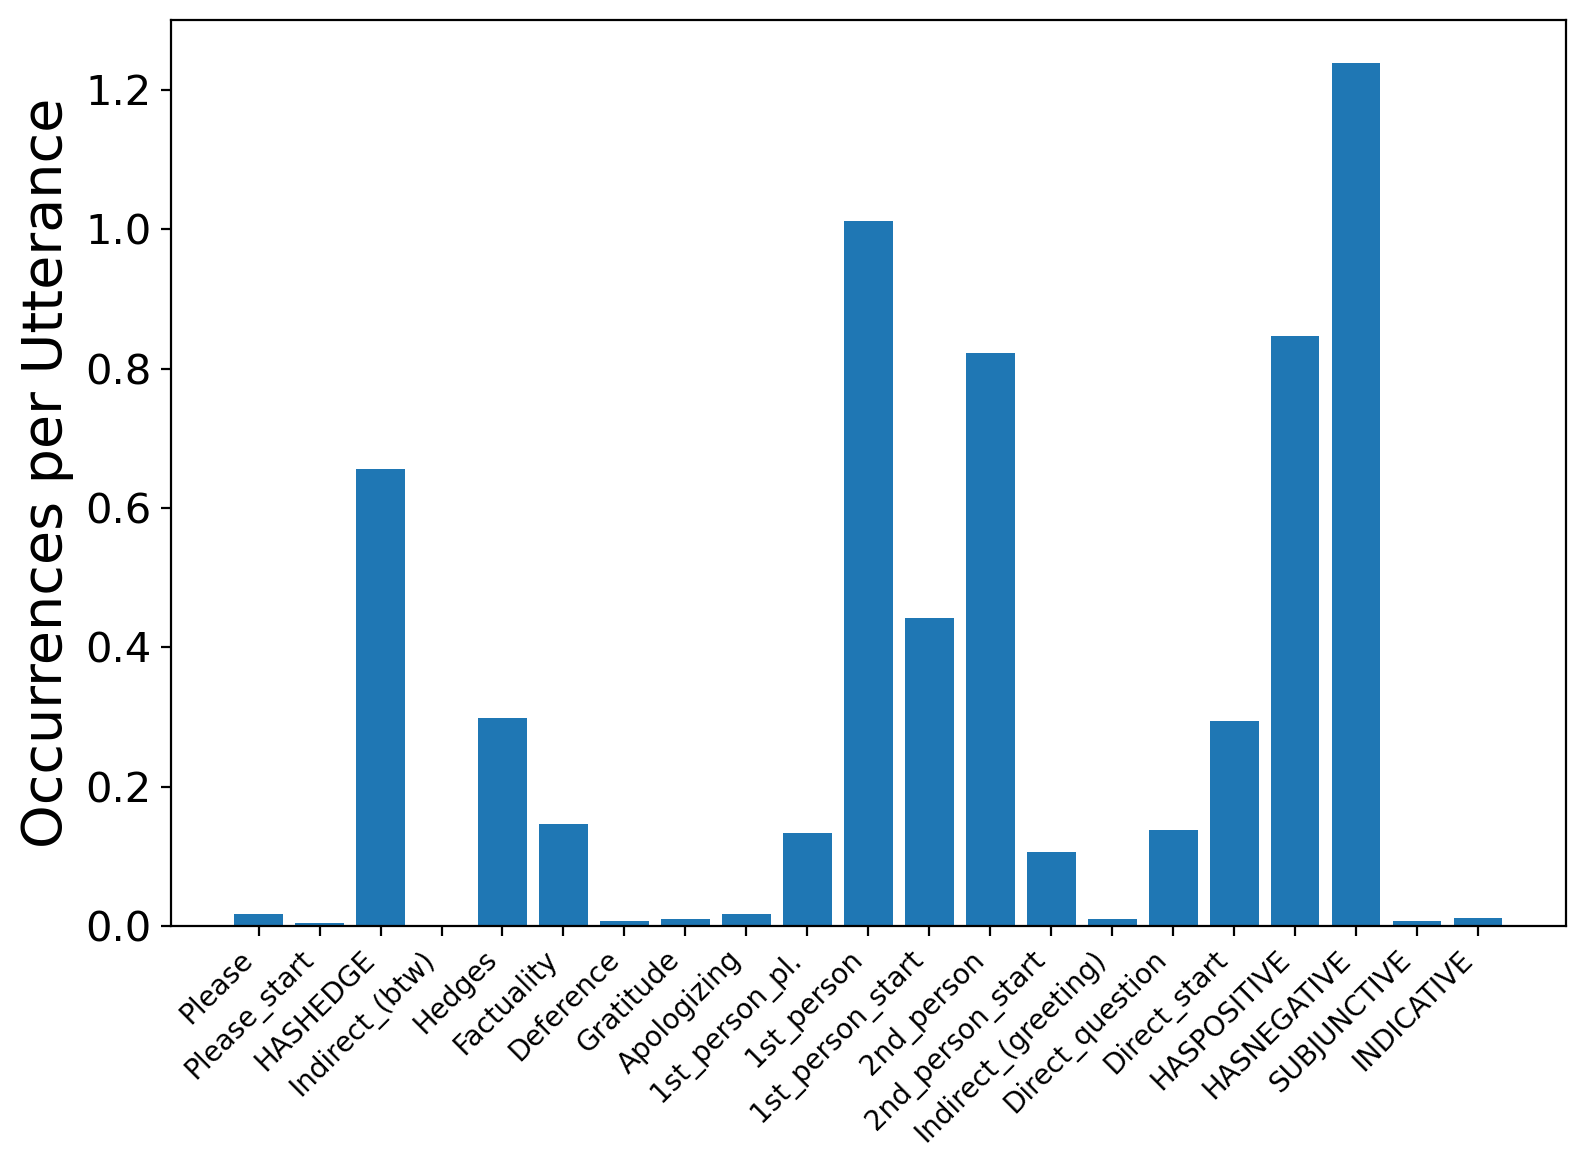

In [187]:
data = ps.summarize(corpus_politeness, plot=True)

Finally, we get the "final" politeness score, by doing a mean of the different politeness strategies. This is a liberty we are taking, as it was not detailed in the original paper.

In [184]:
corpus_politeness.random_utterance().meta['politeness_strategies']

{'feature_politeness_==Please==': 0,
 'feature_politeness_==Please_start==': 0,
 'feature_politeness_==HASHEDGE==': 0,
 'feature_politeness_==Indirect_(btw)==': 0,
 'feature_politeness_==Hedges==': 0,
 'feature_politeness_==Factuality==': 0,
 'feature_politeness_==Deference==': 0,
 'feature_politeness_==Gratitude==': 0,
 'feature_politeness_==Apologizing==': 0,
 'feature_politeness_==1st_person_pl.==': 0,
 'feature_politeness_==1st_person==': 1,
 'feature_politeness_==1st_person_start==': 0,
 'feature_politeness_==2nd_person==': 0,
 'feature_politeness_==2nd_person_start==': 0,
 'feature_politeness_==Indirect_(greeting)==': 0,
 'feature_politeness_==Direct_question==': 0,
 'feature_politeness_==Direct_start==': 0,
 'feature_politeness_==HASPOSITIVE==': 0,
 'feature_politeness_==HASNEGATIVE==': 0,
 'feature_politeness_==SUBJUNCTIVE==': 0,
 'feature_politeness_==INDICATIVE==': 0}

In [ ]:
# TODO: Find a way to get an actual score.

Okay, that was pretty expensive in term of time. Let's save this fresh Corpus so we can reuse it easily later.

In [ ]:
corpus_parsed.dump("corpus_parsed", base_path=os.path.join(PATH_OUTPUT, "corpus_parsed"))
corpus_politeness.dump("corpus_politeness", base_path=os.path.join(PATH_OUTPUT, "corpus_politeness"))

#### Sooo... Is this wolf polite or nah?

In [ ]:
# todo: mean politeness for wolves vs politeness for not wolves

### Talkativeness

In [ ]:
# Talkativeness framework
import seaborn as sns
df = messages_players_expired_outcome_survivors

In [ ]:
nb_messages_betrayers = df[df.betrayer].groupby(['game_id', 'author']).count().content.values
nb_messages_victims = df[~df.betrayer].groupby(['game_id', 'author']).count().content.values

In [ ]:
print(np.median(nb_messages_betrayers), np.median(nb_messages_victims))
print(bootstrap_CI_median(nb_messages_betrayers), bootstrap_CI_median(nb_messages_victims))
print(len(nb_messages_betrayers), len(nb_messages_victims))

In [ ]:
df[df.betrayer].groupby(['game_id', 'author', 'rounds']).describe()

### Wraping up

In [ ]:
# Using the API

---
## Analysis

Something something what are the conclusions?

Further things:
- We can see if the number of times you die is influencing your gameplay

---
## References

- <a name="danescu">**[Danescu-Niculescu-Mizil et al., 2013]**</a>: Cristian Danescu-Niculescu-Mizil, Moritz Sudhof, Dan Jurafsky, Jure Leskovec, Christopher Potts, *A computational approach to politeness with application to social factors*, ACL, 2013. [Original paper](https://nlp.stanford.edu/pubs/politeness.pdf).
- <a name="niculae">**[Niculae et al., 2015]**</a>: Vlad Niculae, Srijan Kumar, Jordan Boyd-Graber, Cristian Danescu-Niculescu-Mizil, *Linguistic Harbingers of Betrayal: A Case Study on an Online Strategy Game*, Proceedings of ACL, 2015. [Original paper](https://vene.ro/betrayal/niculae15betrayal.pdf), [website](https://vene.ro/betrayal/).
- <a name="prasad">**[Prasad et al., 2008]**</a>: Rashmi Prasad, Nikhil Dinesh, Alan Lee, Eleni Miltsakaki, Livio Robaldo, Aravind Joshi, Bonnie Webber, *The Penn Discourse TreeBank 2.0*, LREC, 2008. [Original paper](http://www.lrec-conf.org/proceedings/lrec2008/pdf/754_paper.pdf).
- <a name="deruiter">**[de Ruiter et al., 2018]**</a>: Bob de Ruiter, George Kachergis, *The Mafiascum Dataset: A Large Text Corpus for Deception Detection*, 2018. [Original paper](https://arxiv.org/pdf/1811.07851.pdf).
- <a name="socher">**[Socher et al., 2013]**</a>: Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Christopher Manning, Andrew Ng, Christopher Potts, *Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank*, EMNLP, 2013. [Original paper](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf), [website](https://nlp.stanford.edu/sentiment/).
- <a name="stab">**[Stab et al., 2014]**</a>: Christian Stab, Iryna Gurevych, *Identifying Argumentative Discourse Structures in Persuasive Essay*, EMNLP, 2014. [Original paper](https://www.aclweb.org/anthology/D14-1006.pdf).
- <a name="diplomacy">**Diplomacy**</a>: [Official Website](https://boardgamegeek.com/boardgame/483/diplomacy), [Wikipedia](https://en.wikipedia.org/wiki/Diplomacy_(game)).
- <a name="salem">**Town of Salem**</a>: [Official website](https://www.blankmediagames.com/), [Wikipedia](https://en.wikipedia.org/wiki/Town_of_Salem), [Fandom](https://town-of-salem.fandom.com/wiki/Town_of_Salem_Wiki).
- <a name="hitler">**Secret Hitler**</a>: [Official website](https://www.secrethitler.com/), [Wikipedia](https://en.wikipedia.org/wiki/Secret_Hitler).
- <a name="amongus">**Among Us**</a>: [Official website](http://www.innersloth.com/gameAmongUs.php), [Wikipedia](https://en.wikipedia.org/wiki/Among_Us).
- <a name="mafia">**Werewolf/Mafia**</a>: [Wikipedia](https://en.wikipedia.org/wiki/Mafia_(party_game)), [Telegram game official website](https://www.tgwerewolf.com/), [Mafiascum](https://www.mafiascum.net/).
- <a name="convkit">**ConvKit**</a>: Cornell Conversational Analysis Toolkit. [Website](https://convokit.cornell.edu/).
- <a name="nlpstanford">**Stanford NLP Group**</a>: [Website](https://nlp.stanford.edu/).

---

In [ ]:
from pycorenlp import StanfordCoreNLP
messages_players_expired['sentiment'] = 0
sentiment = []

In [ ]:
sub_sentiment = []
nlp = StanfordCoreNLP('http://localhost:9000')
for index, row_messages in messages_players_expired[0:600].iterrows():
    res = nlp.annotate(row_messages['content'],
                          properties={
                            'annotators': 'sentiment',
                                'outputFormat': 'json',
                              'timeout': 1000000,
                          })
    #print([s['sentimentValue'] for s in res['sentences']])
    sub_sentiment.append((np.sum([int(s['sentimentValue']) > 2 for s in res['sentences']]))/len(res['sentences']))

print(sub_sentiment)

In [ ]:
sentiment += sub_sentiment
sentiment

In [ ]:
np.save()
len(res['sentences'])

In [ ]:
messages_players

In [ ]:
messages_players_expired

In [ ]:
    
    
for s in res["sentences"]:
    print("%d: '%s': %s %s" % (
        s["index"],
        " ".join([t["word"] for t in s["tokens"]]),
        s["sentimentValue"], s["sentiment"]))
    
print(type(res))